## Notebook Objectives

Summarize the Necessary Knowleadge to Apply Clustering Models in Businesses


### About the Models

&emsp;&emsp;_How It Works_    
&emsp;&emsp;_When to Use it_    
&emsp;&emsp;_Advantages_    
&emsp;&emsp;_Disadvantages_    
&emsp;&emsp;_Statistical Assumptions_    
&emsp;&emsp;_Parameters_    
&emsp;&emsp;_More Explanations_

[K-Means](#K-Means)<br>
[DBSCAN](#DBSCAN)<br>
[AgglomerativeClustering](#AgglomerativeClustering)<br>

### Agenda

[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Functions](#Functions)<br>
&emsp;[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>

[Feature Engineering](#Feature-Engineering)<br>

[Preprocessing](#Preprocessing)<br>
&emsp;[Handling Missing Values](#Handling-Missing-Values)<br>
&emsp;[Encoding Categorical Variables](#Encoding-Categorical-Variables)<br>
&emsp;[Scaling/Normalizing Features](#Scaling/Normalizing-Features)<br>
&emsp;[Handling Outliers](#Handling-Outliers)<br>

[Feature Selection](#Feature-Selection)<br>

[Models](#Models)<br>
&emsp;[Choosing The Right Clustering Algorithm](#Choosing-The-Right-Clustering-Algorithm)<br>
&emsp;[K-Means](#K-Means)<br>
&emsp;[DBSCAN](#DBSCAN)<br>
&emsp;[AgglomerativeClustering](#AgglomerativeClustering)<br>

[Evaluation Metrics](#Evaluation-Metrics)<br>
&emsp;[Choosing the Right Metric](#Choosing-the-Right-Metric)<br>

[Feature Importances](#Feature-Importances)<br>

[Cluster Analysis](#Cluster-Analysis)<br>
&emsp;[Clusters Distances](#Clusters-Distances)<br>
&emsp;[Clusters Behaviors](#Clusters-Behaviors)<br>
&emsp;[In Depth Analysis](#In-Depth-Analysis)<br>

[Cluster Profiles](#Cluster-Profiles)<br>
&emsp;&emsp;[Business Opportunity Map](#Customer-Profiles/Business-Opportunity-Map)<br>
&emsp;&emsp;[Business Descriptions](#Business-Descriptions)<br>

## Business Questions

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Ensure you import Axes3D
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, cdist

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



import warnings
warnings.filterwarnings("ignore")


### Functions

In [3]:
def plot_cluster_boxplots(data, cluster_col, variable_a, variable_b, showfliers=False, horizontal_line_at=0):
    """
    Plot boxplots for sales and profit by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a
    - variable_b: The name of the column representing variable_b
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=cluster_col, y=variable_a, data=data, showfliers=showfliers)
    plt.title(f'{variable_a} by {cluster_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cluster_col, y=variable_b, data=data, showfliers=showfliers)
    plt.title(f'{variable_b} by {cluster_col}')
    
    plt.axhline(horizontal_line_at, color='r')

    plt.tight_layout()
    plt.show()


def plot_cluster_analysis(data, cluster_col, variable_a, variable_b, palette='mako'):
    """
    Plot countplot for clusters and scatterplot for recency vs frequency by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a.
    - variable_b: The name of the column representing variable_b.
    - palette: Color palette for the plots (default is 'mako').
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=cluster_col, data=data, palette=palette)
    plt.title(f'Count of {cluster_col} Clusters')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=data, x=variable_a, y=variable_b, hue=cluster_col, palette=palette)
    plt.title(f'{variable_a} vs {variable_b} by {cluster_col}')

    plt.tight_layout()
    plt.show()

### Settings

In [4]:
pd.set_option("display.max_columns", None)

### Loading Data

In [5]:
df_customer_abt = sns.load_dataset('iris')
df_customer_abt = df_customer_abt.rename(columns={
    "sepal_length": "customer_age",
    "sepal_width": "annual_income",
    "petal_length": "monthly_spending",
    "petal_width": "credit_score",
    "species": "customer_segment"
})

# Adjust the values to fit a business context
df_customer_abt["customer_age"] = (df_customer_abt["customer_age"] * 5).astype(int)  # Scale to age range
df_customer_abt["annual_income"] = (df_customer_abt["annual_income"] * 10000).round(2)  # Scale to income
df_customer_abt["monthly_spending"] = (df_customer_abt["monthly_spending"] * 500).round(2)  # Scale to spending
df_customer_abt["credit_score"] = (df_customer_abt["credit_score"] * 40).round(2)  # Scale loyalty score

np.random.seed(42)  # Set seed for reproducibility
df_customer_abt["customer_tenure"] = np.random.normal(loc=5, scale=2, size=len(df_customer_abt)).clip(0).round(1)
df_customer_abt["purchase_frequency"] = np.random.exponential(scale=10, size=len(df_customer_abt)).round(1)
df_customer_abt["preferred_channel"] = np.random.choice(['Online', 'In-Store', 'Hybrid'], size=len(df_customer_abt))

df_customer_abt.head()

,customer_age,annual_income,monthly_spending,credit_score,customer_segment,customer_tenure,purchase_frequency,preferred_channel
0,25,35000.0,700.0,8.0,setosa,6.0,21.8,Hybrid
1,24,30000.0,700.0,8.0,setosa,4.7,15.1,In-Store
2,23,32000.0,650.0,8.0,setosa,6.3,10.3,In-Store
3,23,31000.0,750.0,8.0,setosa,8.0,0.9,Hybrid
4,25,36000.0,700.0,8.0,setosa,4.5,1.8,In-Store


## Feature Engineering

## Preprocessing

### Handling Missing Values

In [6]:
print(f"Original Shape: {df_customer_abt.shape}")
df_customer_abt = df_customer_abt.dropna()
print(f"After Dropna Shape: {df_customer_abt.shape}")

Original Shape: (150, 8)
After Dropna Shape: (150, 8)


### Encoding Categorical Variables

### Handling Outliers

## Feature Selection

In [7]:
features = df_customer_abt.select_dtypes('number').columns
categories = df_customer_abt.select_dtypes(object).columns

df_customer_abt[features].head(2)

,customer_age,annual_income,monthly_spending,credit_score,customer_tenure,purchase_frequency
0,25,35000.0,700.0,8.0,6.0,21.8
1,24,30000.0,700.0,8.0,4.7,15.1


### Scaling/Normalizing Features

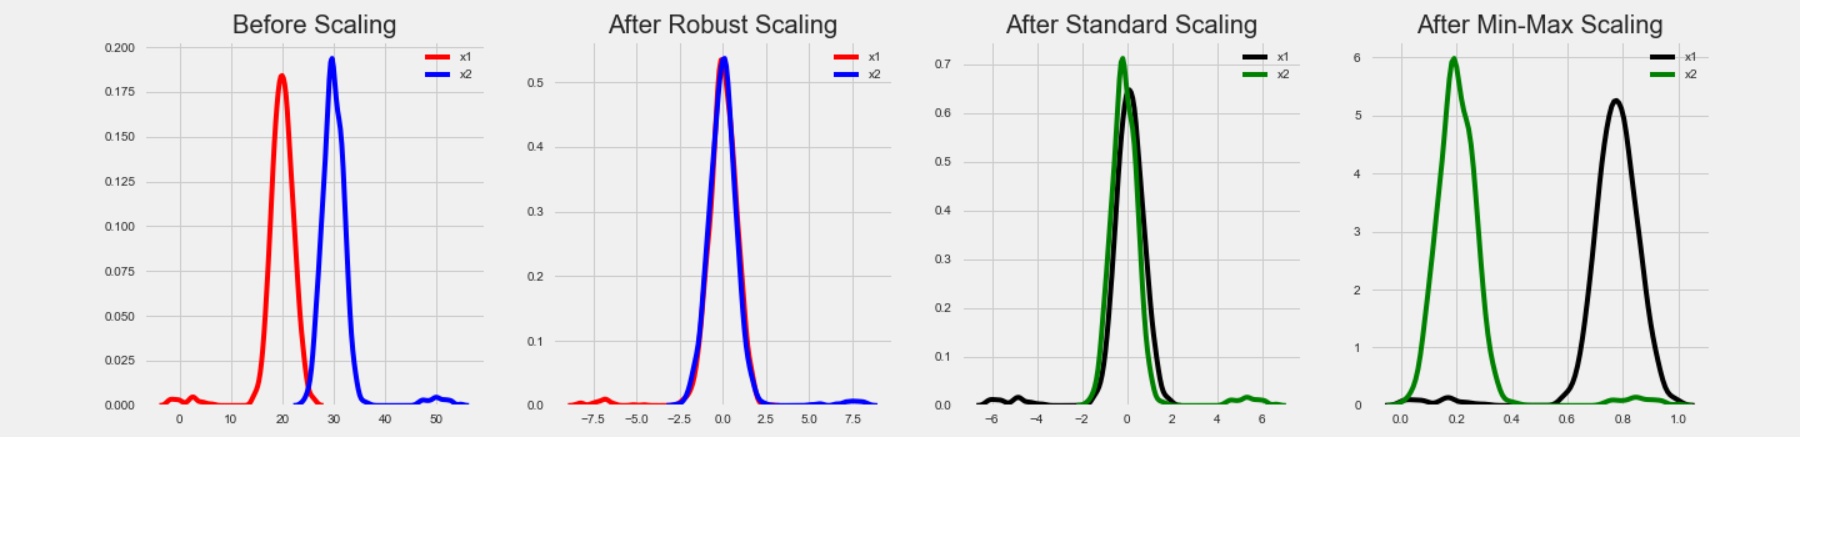

In [24]:
df_customer_abt_scaled = df_customer_abt.copy()

# scaler = MinMaxScaler()
# df_customer_abt = pd.DataFrame(scaler.fit_transform(df_customer_abt[features]), columns=features)

df_customer_abt_scaled = pd.DataFrame(normalize(df_customer_abt_scaled[features]), columns=features)

## Models

### Choosing The Right Clustering Algorithm

Choosing The Right Clustering Algorithm involves factors as

        Shape and Distribution.
        Dataset size.
        Noise and outliers.
        Dimensionality.

Performing an [Exploratory Data Analysis](https://github.com/pauloreis-ds/machine-learning-essentials/tree/main/clustering/p01v01_eda.ipynb) is essential to understand the structure and distribution of the data before applying clustering algorithms.

### K-Means


**How It Works:** StatQuest: K-means clustering (https://www.youtube.com/watch?v=4b5d3muPQmA&t)



- **When to Use it:**

    Useful in scenarios where you expect clusters to have somewhat spherical shape (convex data) and roughly equal sizes.    

    When Data Points naturally form distinct, well-separated spherical clusters.    


- **Advantages**

    Easy to Interpret: K-means provides clear cluster centers, making it easier to interpret clusters and use them for subsequent tasks like classification or segmentation.    

    Scalability (It's Fast): ideal for large datasets due to its computational efficiency.    


- **Disadvantages**


    Assumption of Spherical Clusters: it performs poorly with (non-convex data) elongated or irregularly shaped clusters.    
    
    Sensitivity to Outliers: because it uses the "mean" to readjust clusters, centroids can be dragged by outliers, distorting the centroids.       

    Sensitive to Initialization: results depend heavily on the initial positions of centroids.   

    Cluster Size Imbalance: it tends to split larger clusters and merge smaller ones, failing to properly represent data with clusters of unequal sizes. Ex: a dataset with one large group of 10,000 points and a smaller group of 100 points. K-means might allocate multiple centroids to the larger group while merging the smaller group into another cluster, and that's because We set the quantity of clusters beforehand.

    Lacks Consistency: it gives varying results on different runs of an algorithm.   

    



- **Statistical Assumptions**

    Clusters are Spherical
    
    Homoscedasticidy: variable have the same variance. The spread or dispersion of the data points is consistent across all variables (it is uniform in all dimensions). The variance is the same in all directions from the center of the cluster. This  assumption is important because it ensures thateach feature contributes equally to the analysis. High variance affects the model because it causes a variable to have outliers which affects the mean (disproportionately influencing the estimates of model parameters).    

    Linear Separability: K-means assumes that clusters are linearly separable. Each cluster can be separated from others by a straight line (in two dimensions) or a hyperplane (in higher dimensions). Therefore spiral clusters are not a good match for K-means.    

    "Mean" as a Good Cluster Representation: K-means relies on centroids, meaning it works best when the mean is a meaningful representation of the cluster. Example: when data is symmetrically distributed (equal mean, median and mode, making the centroid (mean) a good representative).    

    Variables are Independent: each variable provides unique information and knowing the value of one variable does not give any information about the value of another variable. Highly correlated features can distort the distance metric and affect clustering results. Correlated features provide redundant information, which can lead to overemphasis on certain dimensions (giving indue weight to these features and skewing the clustering results). Besides, they can result in elogated/elliptical clusters. Thus, the centroids may not accuratly represent the true center of the clusters.    

    Prior probability for all clusters are the same: each cluster has roughly equal number of observations. "You don't have any reason to believe one cluster is more likely than another, you assume each cluster has an equal chance of containing any given data point". K-means minimizes the sum of squared distances. The centroid of each cluster is updated by calculating the mean of all points assigned to that cluster (this new centroid minimizes the SSD for the current cluster assignment) and this averaging process assumes that all points within a cluster contribute equally. So, k-Means assumes each cluster has the same size because the distance metric (using the mean) assumes it.    

    Feature Importance/Scaling: K-means typically uses Euclidean distance, so it assumes data features are equally scaled. Features with larger ranges can dominate the distance calculation, leading to biased results. Proper normalization (or standardization) is essential.    

    


- **Parameters**

    K: number of clusters you want to segment the data.    
    
        How to to choose K:
            Elbow Method: Plot the (inertia) sum of squared distances (SSD) for different K values and look for the "elbow point" where the rate of decrease slows down. You can also use distortion, the average of squared distances, to emphasize similarity between observations in the cluster.    

            Silhouette Score: Measures how similar points are within their own cluster compared to other clusters.    

    Max Iterations: the maximum number of iterations the algorithm will run to refine the centroids. It can prevent the algorithm from running indefinitely in case it doesn’t converge.

    Initialization Method: centroid initialization. It determines how to initialize the centroids before starting the K-means algorithm.
    
        The two main options are:
            Random Initialization: Centroids are chosen randomly from the data points. This can lead to poor results or slow convergence.
            
            K-means++ Initialization: A smarter way to initialize centroids by spreading them out, which tends to result in better clustering and faster convergence.


- **More Explanations**

    Manhattan Distance vs Euclidean Distance: manhattan for high dimensionality, as high dimensionality often leads to difficulty in distinguishing distances between one point and the other. Manhattan does better than Euclidean once we move up to higher dimensional space because each dimension contributes linearly to the distance (avoiding quadratic amplification of differences as seen in Euclidean Distance), providing more balanced distances and reducing the impact of dominant dimensions or outliers.

    Inertia VS Distortion: choosing K number of clusters (Elbow Method).     
        
        Inertia is defined as the sum of squared distances from each point to its cluster centroid.    
        Smaller values correspond to tighter clusters, this means we are penalizing spread out clusters and rewarding compact clusters (tighter to their centroid).    
        It's sensitive to the dataset size (due to the sum). The more observations you add the more you'll penalize the inertia, even if observations are closer to the centroid.    

        Distortion is the average of squared distances from each point to its cluster centroid.    
        Smaller values also correspond to tighter clusters. It is not penalized as more observations are added (because it calculates the average) and closer points to the centroid will actually reward distortion (whereas inertia also depends on the number of points and no tonly the distance)    

        When the similarity of the cluster members are relevant, you should use distortion.    
        If you're more concerned that clusters should have a similar number of members, use inertia then.    

  File "C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


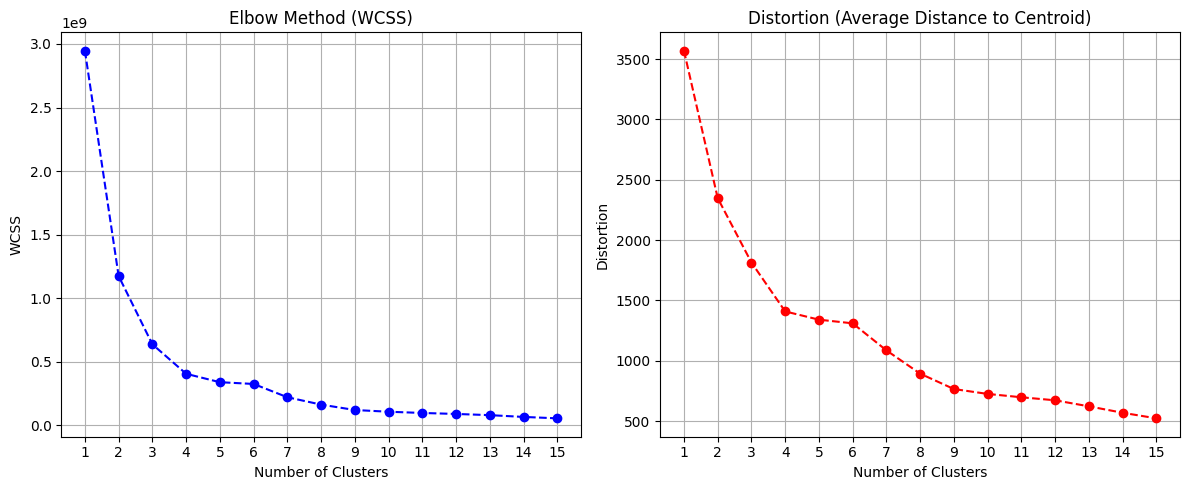

In [9]:
# Within-Cluster Sum of Squares.
wcss = [] 
distortions = []
max_clusters = 15


# Loop through different cluster counts
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, max_iter=500)
    kmeans.fit(df_customer_abt[features])
    wcss.append(kmeans.inertia_)
    
    # Distortion (Average Distance to Centroid)
    _, distances = pairwise_distances_argmin_min(df_customer_abt[features], kmeans.cluster_centers_)
    distortions.append(np.mean(distances))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--', color='r')
plt.title('Distortion (Average Distance to Centroid)')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
df_customer_abt.columns

Index(['customer_age', 'annual_income', 'monthly_spending', 'credit_score',
       'customer_segment', 'customer_tenure', 'purchase_frequency',
       'preferred_channel', 'cluster_kmeans'],
      dtype='object')

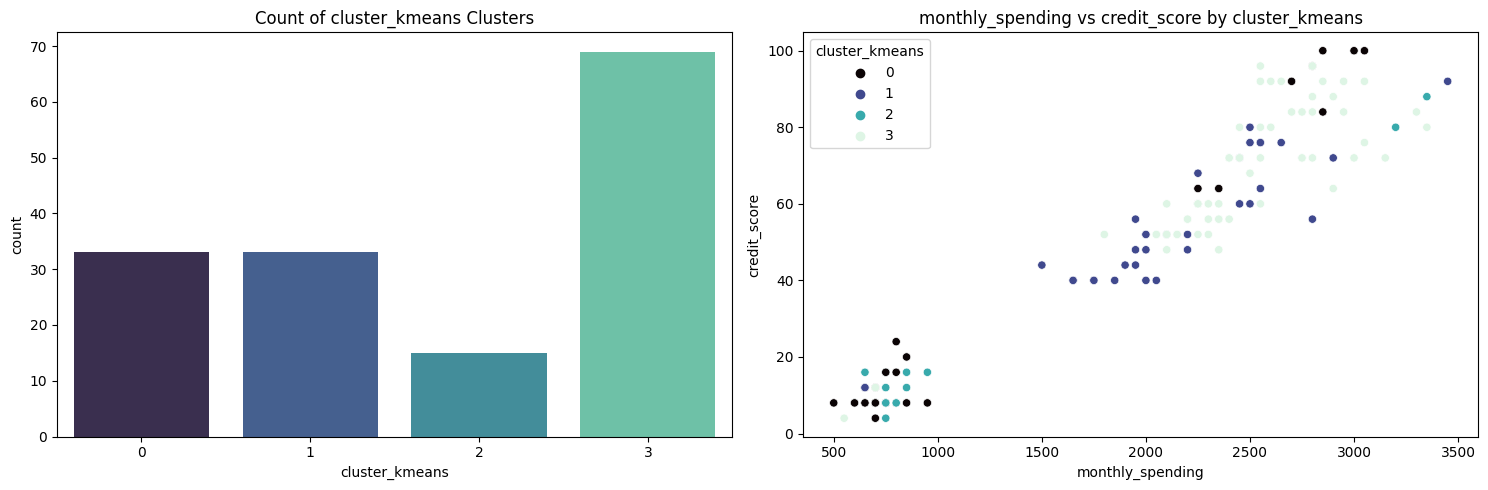

CPU times: total: 1.64 s
Wall time: 267 ms


In [11]:
%%time
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=500)
df_customer_abt['cluster_kmeans'] = kmeans.fit_predict(df_customer_abt[features])

plot_cluster_analysis(df_customer_abt, 'cluster_kmeans', 'monthly_spending', 'credit_score', palette='mako')

In [11]:
df_customer_abt.columns

Index(['Customer ID', 'total_sales', 'avg_ticket', 'total_products',
       'avg_produtcs_per_purchase', 'median_discount', 'avg_discount',
       'std_discount', 'total_profit', 'avg_profit', 'total_shipping_cost',
       'avg_shipping_cost', 'segment', 'market', 'most_used_ship_mode',
       'cluster_kmeans'],
      dtype='object')

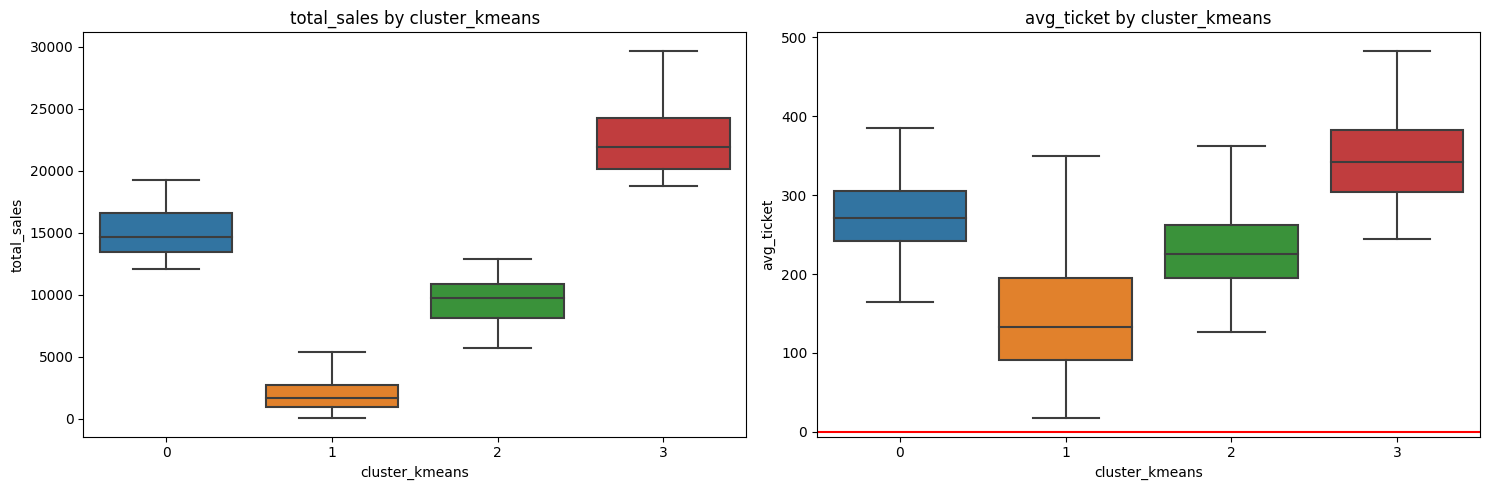

In [12]:
plot_cluster_boxplots(df_customer_abt, 'cluster_kmeans', 'total_sales', 'avg_ticket')

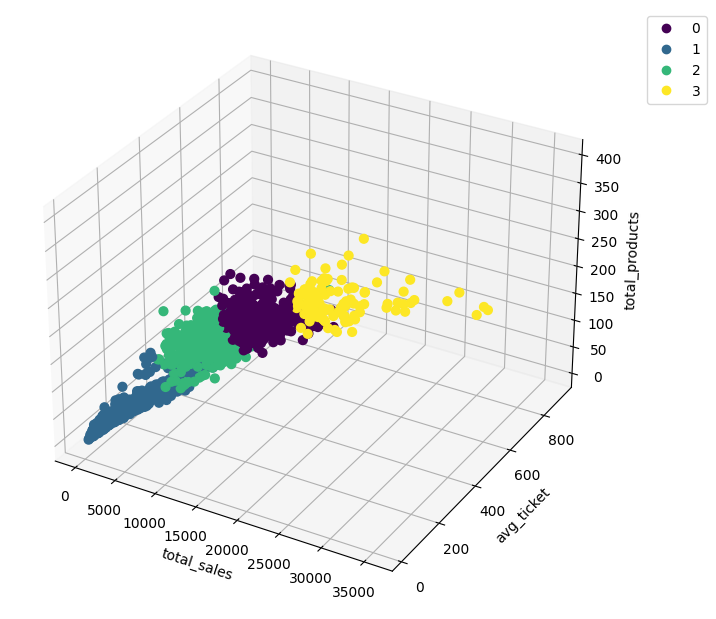

In [15]:
df_temp = df_customer_abt.copy()#[df_customer_abt['value'] < customer_abt['value'].quantile(.95)]

variables = ['total_sales', 'avg_ticket', 'total_products']

x = df_temp[variables[0]]
y = df_temp[variables[1]]
z = df_temp[variables[2]]
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


# plot
sc = ax.scatter(x, y, z, s=40, c=df_temp['cluster_kmeans'], marker='o', alpha=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

#### Rescaled

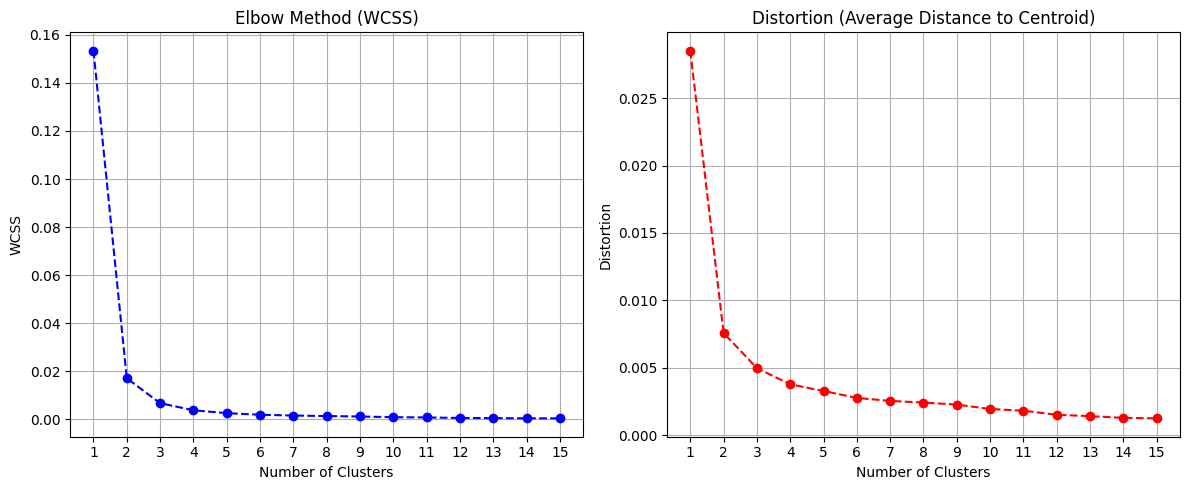

In [26]:
# Within-Cluster Sum of Squares.
wcss = [] 
distortions = []
max_clusters = 15


# Loop through different cluster counts
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, max_iter=500)
    kmeans.fit(df_customer_abt_scaled[features])
    wcss.append(kmeans.inertia_)
    
    # Distortion (Average Distance to Centroid)
    _, distances = pairwise_distances_argmin_min(df_customer_abt_scaled[features], kmeans.cluster_centers_)
    distortions.append(np.mean(distances))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--', color='r')
plt.title('Distortion (Average Distance to Centroid)')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.tight_layout()
plt.show()

In [14]:
features

Index(['customer_age', 'annual_income', 'monthly_spending', 'credit_score',
       'customer_tenure', 'purchase_frequency'],
      dtype='object')

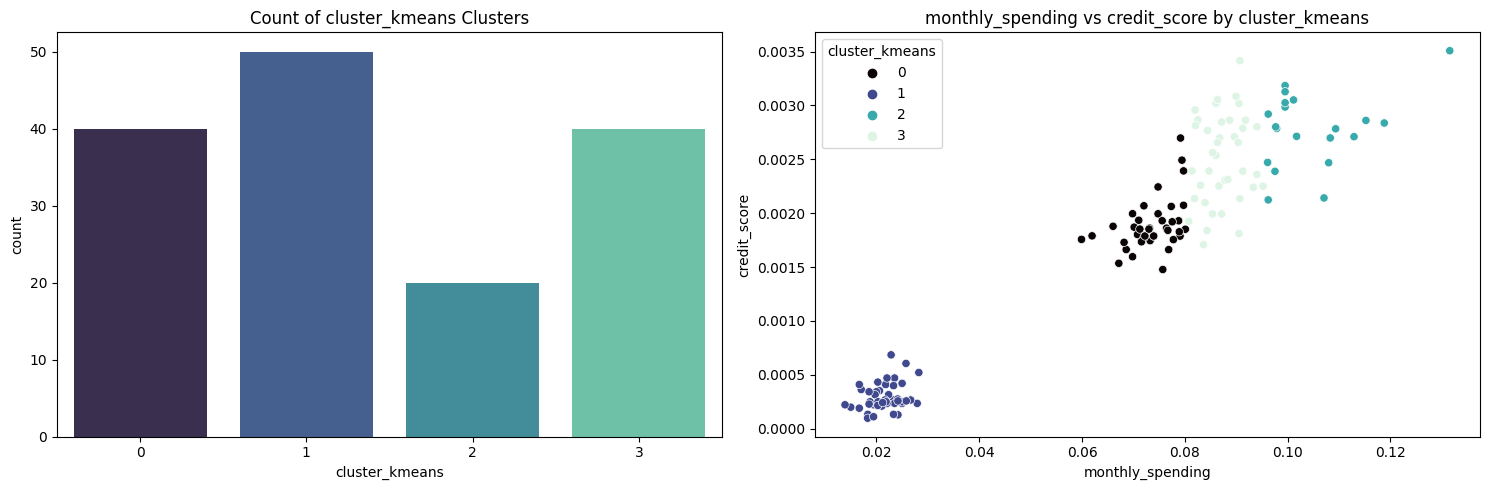

CPU times: total: 1.27 s
Wall time: 236 ms


In [28]:
%%time
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=500)
df_customer_abt_scaled['cluster_kmeans'] = kmeans.fit_predict(df_customer_abt_scaled)
df_customer_abt['cluster_kmeans_scaled'] = kmeans.fit_predict(df_customer_abt_scaled)

plot_cluster_analysis(df_customer_abt_scaled, 'cluster_kmeans', 'monthly_spending', 'credit_score', palette='mako')

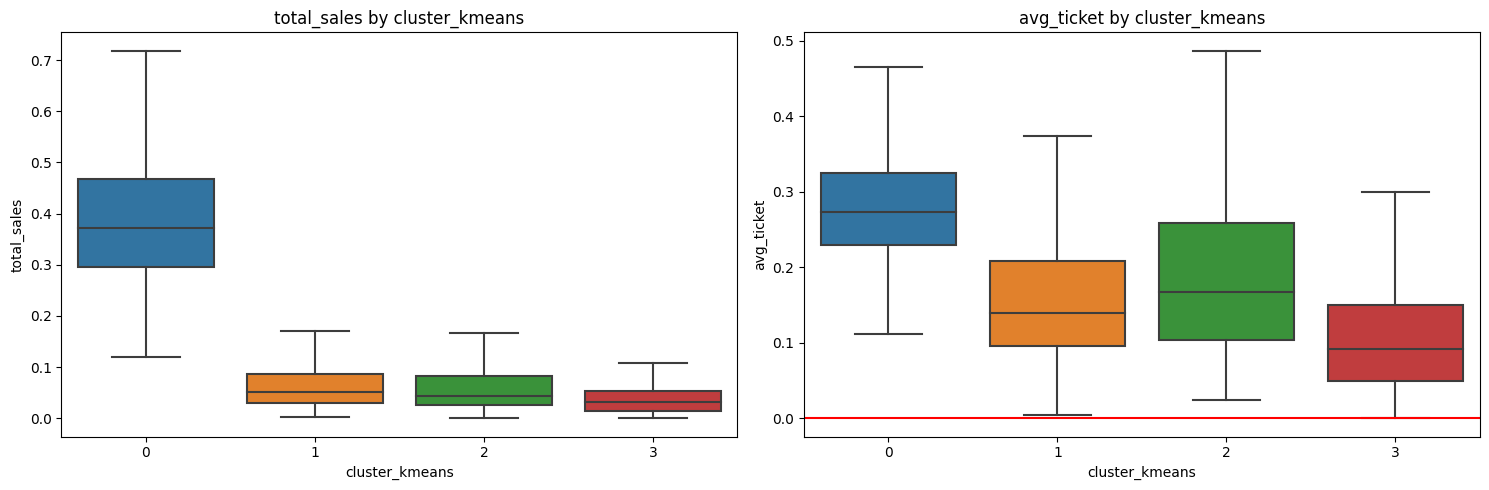

In [18]:
plot_cluster_boxplots(df_customer_abt_scaled, 'cluster_kmeans', 'total_sales', 'avg_ticket')

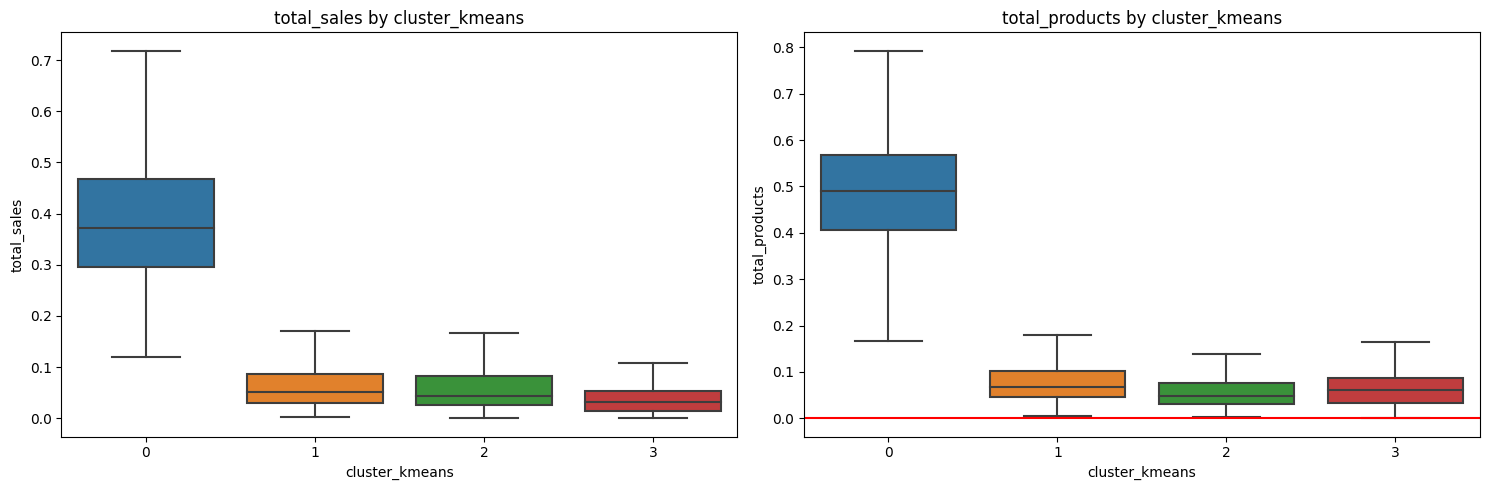

In [19]:
plot_cluster_boxplots(df_customer_abt_scaled, 'cluster_kmeans', 'total_sales', 'total_products')

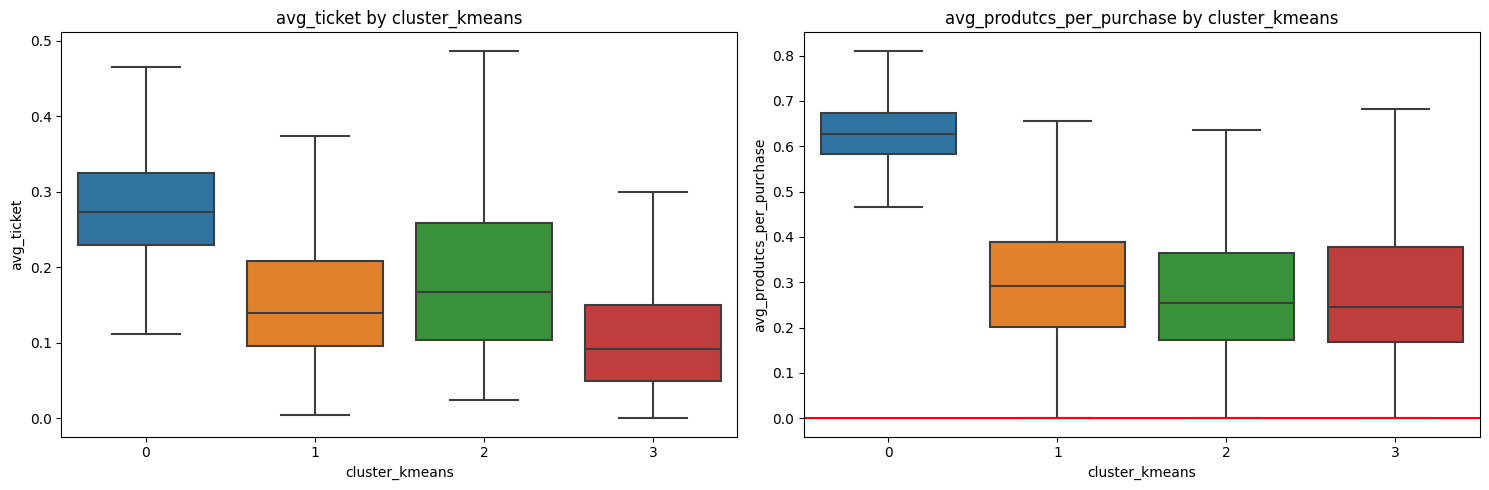

In [20]:
plot_cluster_boxplots(df_customer_abt_scaled, 'cluster_kmeans', 'avg_ticket', 'avg_produtcs_per_purchase')

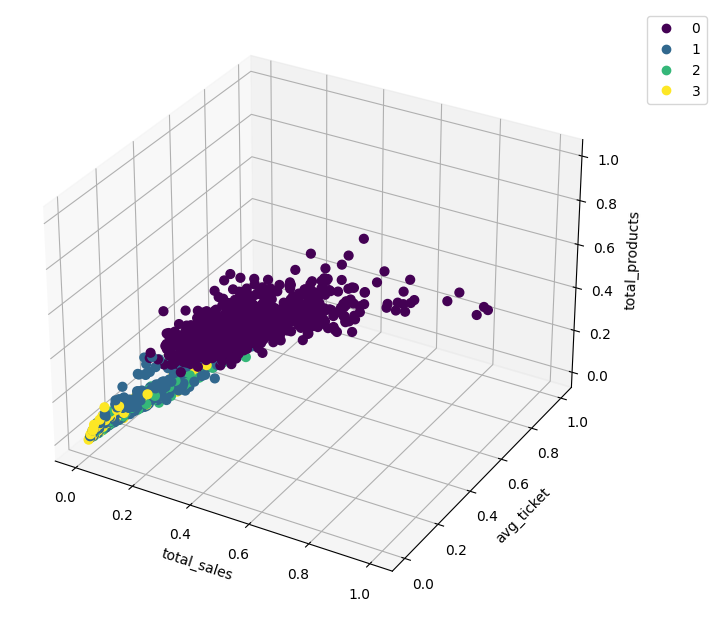

In [21]:
df_temp = df_customer_abt_scaled.copy()#[df_customer_abt_scaled['value'] < customer_abt['value'].quantile(.95)]

variables = ['total_sales', 'avg_ticket', 'total_products']

x = df_temp[variables[0]]
y = df_temp[variables[1]]
z = df_temp[variables[2]]
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


# plot
sc = ax.scatter(x, y, z, s=40, c=df_temp['cluster_kmeans'], marker='o', alpha=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

## Evaluation Metrics

# Clustering Evaluation Metrics

### 1. **Silhouette Score**

Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).    

It ranges from 1 (well-clustered) to -1 (misclassified)

**Advantages:**
- interpretable Results.
- It measures both how tightly points are grouped within clusters and how well-separated clusters are.

**Limitations:**
- Sensitive to noise and outliers.
- Scalability: computationally expensive (due to pairwise distances).

**Formula**: 

For a data point \( i \):

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$


Where:
- a(i): Average distance from (i) to all other points in the same cluster.
- b(i): Average distance from (i) to all points in the nearest cluster.



---

### 2. **Dunn Index**
Measures the ratio of the minimum inter-cluster (between different clusters) distance to the maximum intra-cluster (within the cluster) distance.

Higher Values indicates better clustering.

**Advantages:**
- Compactness and Separation: it combines intra-cluster compactness and inter-cluster separation.
- Encourages Well-Separated Clusters: higher values indicate clusters are both compact and well-separated.

**Limitations:**
- Sensitive to noise and outliers: they can distort inter-cluster distances.
- Not Widely implemented in libraries.


**Formula**:
$$
\text{Dunn Index} = \frac{\min(\text{inter-cluster distances})}{\max(\text{intra-cluster distances})}
$$

---

### 3. **Davies-Bouldin Index**

Measures the average similarity ratio of each cluster with the cluster that is most similar to it.

Lower Values indicate better clustering.

**Advantages:**
- Accounts for intra-cluster compactness and inter-cluster separation.
- Computationally efficient.

**Limitations:**
- Sensitive to cluster size variations.


**Formula**:
$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d_{ij}}
$$


  Where:
  - k is the number of clusters
  - sigma i: Average distance of all points in cluster \( i \) to the centroid of cluster \( i \) (intra-cluster scatter).
  - sigma j: Average distance of all points in cluster \( j \) to the centroid of cluster \( j \) (intra-cluster scatter).
  - d ij: Distance between centroids of clusters \( i \) and \( j \) (inter-cluster distance).


---

### 4. **Calinski-Harabasz Index (Variance Ratio Criterion)**

Measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion.

In other words, ratio of the variance between clusters to the variance within clusters.

It is particularly useful for determining the optimal number of clusters in a dataset.

Higher Values indicate better-defined clusters. This means clusters are well-separated and points within each clusters are compact.

**Advantages:**
- Computationally Efficient.
- Scale-Invariant: it is not affected by the scale of the data, as it relies on the ratio of between-cluster dispersion and within-cluster dispersion.

**Limitations:**
- Sensitive to noise and outliers: they can significantly affect the within-cluster dispertion (SSW), leading to misleading values of the index.
- Sensitive to the number of clusters: it can favor larger number of clusters, especially in cases where the dara has a high-dimensional space or outliers.


**Formula**:
$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$
  Where:
  - \( \text{Tr}(B_k) \): Trace of between-cluster dispersion matrix.
  - \( \text{Tr}(W_k) \): Trace of within-cluster dispersion matrix.
  - \( n \): Number of data points.
  - \( k \): Number of clusters.

<br>

<br>


**More Explanations**

Balancing Compactness and Separation applies to both Dunn Index and Davies-Bouldin Index. However, there are differences in how they achieve this.

Dunn Index uses extreme values (smallest inter-cluster distance, largest intra-cluster distance) to assess the worst-case scenario for clustering quality and is sensitive to noise and outliers.

Davies-Bouldin Index averages dispersion and separation over all clusters, making it less sensitive to individual clusters but more prone to favoring spherical shapes (due to its reliance on metrics that assume compactness around centroid).

Dunn Index is explicity designed to measure both compactness (intra-cluster distance) and separation (inter-cluster distance).

        It uses the smallest inter-cluster distance to represent separation
        and largest intra-cluster distance to represent compactness.

Davies-Bouldin Index balances compactness and separation indirectly.

        It uses the distance between clusters centroids to represent separation
        and intra-cluster Dispersion to represent compactness.

In [51]:
print("Silhouette Score:")
silhouette_avg = silhouette_score(df_customer_abt[features], df_customer_abt['cluster_kmeans'])
print("cluster_kmeans:", silhouette_avg)
silhouette_avg = silhouette_score(df_customer_abt[features], df_customer_abt['cluster_dbscan'])
print("cluster_dbscan:", silhouette_avg)
silhouette_avg = silhouette_score(df_customer_abt[features], df_customer_abt['cluster_agg'])
print("cluster_agg:", silhouette_avg)


Silhouette Score:
cluster_kmeans: 0.6001108782825681
cluster_dbscan: 0.08507847564948862
cluster_agg: 0.14829755831404287


In [52]:
print("Davies-Bouldin Index:")
db_index = davies_bouldin_score(df_customer_abt[features], df_customer_abt['cluster_kmeans'])
print("cluster_kmeans:", db_index)
db_index = davies_bouldin_score(df_customer_abt[features], df_customer_abt['cluster_dbscan'])
print("cluster_dbscan:", db_index)
db_index = davies_bouldin_score(df_customer_abt[features], df_customer_abt['cluster_agg'])
print("cluster_agg:", db_index)


Davies-Bouldin Index:
cluster_kmeans: 0.6093758172412904
cluster_dbscan: 3.0132573009979255
cluster_agg: 3.095557875693275


In [154]:
print("Dunn Index:")
## TO DO
## Dunn Index


Dunn Index:


In [53]:
print("Calinski-Harabasz Index:")
ch_score = calinski_harabasz_score(df_customer_abt[features], df_customer_abt['cluster_kmeans'])
print("cluster_kmeans:", ch_score)
ch_score = calinski_harabasz_score(df_customer_abt[features], df_customer_abt['cluster_dbscan'])
print("cluster_dbscan:", ch_score)
ch_score = calinski_harabasz_score(df_customer_abt[features], df_customer_abt['cluster_agg'])
print("cluster_agg:", ch_score)

Calinski-Harabasz Index:
cluster_kmeans: 5647.723905588388
cluster_dbscan: 529.2474341688743
cluster_agg: 1982.0016428105314


### Choosing the Right Metric

## Feature Importances

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_customer_abt[features], df_customer_abt['cluster_kmeans'], test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5,random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       104
           1       1.00      0.99      0.99       227
           2       0.97      0.99      0.98       108
           3       1.00      1.00      1.00        36

    accuracy                           0.99       475
   macro avg       0.99      0.99      0.99       475
weighted avg       0.99      0.99      0.99       475



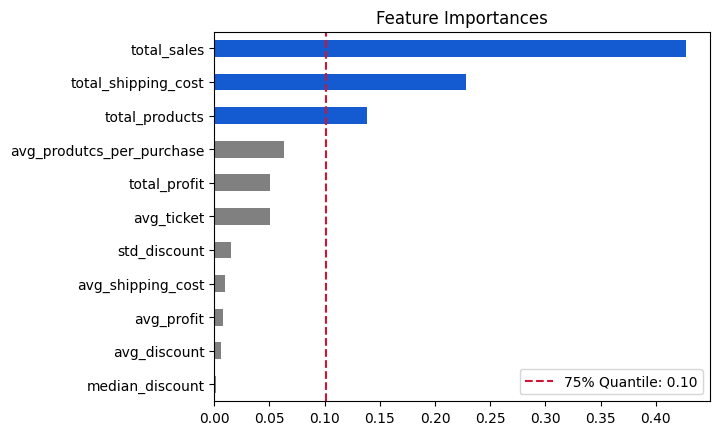

In [34]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

# Define the quantile threshold
x_quantile = 0.75
threshold = feature_importances.quantile(x_quantile)
colors = ['grey' if importance < threshold else '#145ad0' for importance in feature_importances]

feature_importances.plot.barh(color=colors
                            #   , figsize=(10, 6)
                              )
plt.axvline(threshold, c='#d01433', linestyle='--', label=f'{round(x_quantile*100)}% Quantile: {threshold:.2f}')
plt.legend()
plt.title("Feature Importances")
plt.show()

## Cluster Analysis

You can also try exploring more with heatmaps

In [81]:
analysis_cols = features

[]

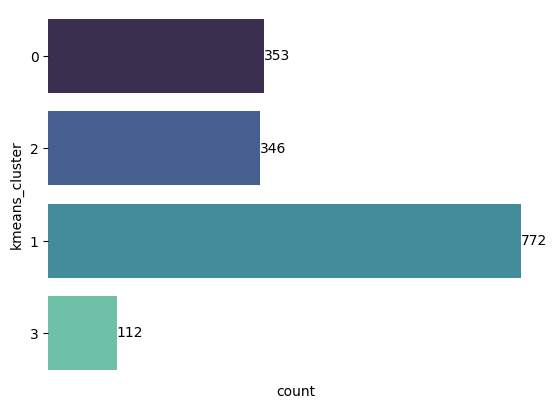

In [82]:
ax = sns.countplot(y='cluster_kmeans', data=df_customer_abt, palette='mako')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
ax.set_xticks([])

### Cluster Distances

In [ ]:
# Ensure 'cluster_kmeans' is treated as categorical
df_customer_abt['cluster_kmeans'] = df_customer_abt['cluster_kmeans'].astype(str)

# Initialize lists to store the results
within_cluster_distances = []
between_cluster_distances = []

# Loop through each cluster to calculate within-cluster distances
for cluster in df_customer_abt['cluster_kmeans'].unique():
    # Filter the data for the current cluster
    cluster_data = df_customer_abt[df_customer_abt['cluster_kmeans'] == cluster]
    
    # Select the relevant features for distance calculation
    features = cluster_data[['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']].values
    
    # Calculate pairwise Euclidean distances within the cluster
    dist_matrix = pdist(features, metric='euclidean')
    
    # Compute the average and standard deviation of distances within the cluster
    avg_distance_within = np.mean(dist_matrix)
    std_distance_within = np.std(dist_matrix)
    
    within_cluster_distances.append((cluster, avg_distance_within, std_distance_within))

# Now calculate the centroids for each cluster
centroids = df_customer_abt.groupby('cluster_kmeans')[['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']].mean()

# Calculate pairwise distances between centroids
centroid_distances = cdist(centroids, centroids, metric='euclidean')

# Flatten the centroid distances and compute the average and standard deviation
avg_distance_between_clusters = np.mean(centroid_distances[np.triu_indices_from(centroid_distances, k=1)])
std_distance_between_clusters = np.std(centroid_distances[np.triu_indices_from(centroid_distances, k=1)])

# Store results for within-cluster distances in a DataFrame
within_cluster_df = pd.DataFrame(within_cluster_distances, columns=['Cluster', 'Avg Distance Within', 'Std Distance Within'])

# Display the results
print("Within Cluster Distances:")
print(within_cluster_df)

# Display the average and standard deviation of distances between clusters
print(f"\nAverage Distance Between Clusters: {avg_distance_between_clusters:.2f}")
print(f"Standard Deviation of Distance Between Clusters: {std_distance_between_clusters:.2f}")


Within Cluster Distances:
  Cluster  Avg Distance Within  Std Distance Within
0       0            54.355468            33.614110
1       2            67.132431            52.415564
2       1            55.232287            51.564857
3       3            66.978018            40.583739

Average Distance Between Clusters: 121.35
Standard Deviation of Distance Between Clusters: 64.18


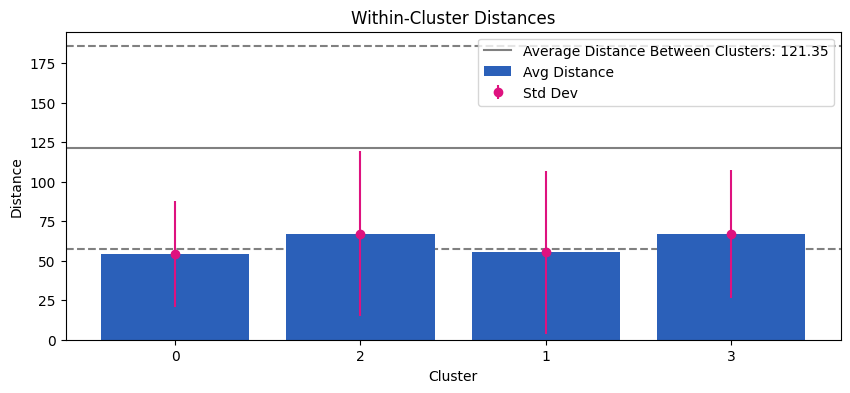

In [75]:
# Plot within-cluster distances
plt.figure(figsize=(10, 4))
sns.barplot(data=within_cluster_df, x='Cluster', y='Avg Distance Within', color='#145ad0', label='Avg Distance')
plt.errorbar(x=within_cluster_df['Cluster'], 
             y=within_cluster_df['Avg Distance Within'], 
             yerr=within_cluster_df['Std Distance Within'], 
             fmt='o', color='#de127f', label='Std Dev')
plt.title('Within-Cluster Distances')
plt.xlabel('Cluster')
plt.ylabel('Distance')



plt.axhline(avg_distance_between_clusters, c='grey', linestyle='-', label=f'Average Distance Between Clusters: {avg_distance_between_clusters:.2f}')
plt.axhline(avg_distance_between_clusters+std_distance_between_clusters, c='grey', linestyle='--', zorder=0)
plt.axhline(avg_distance_between_clusters-std_distance_between_clusters, c='grey', linestyle='--', zorder=0)

plt.legend(loc='upper right')
plt.show()

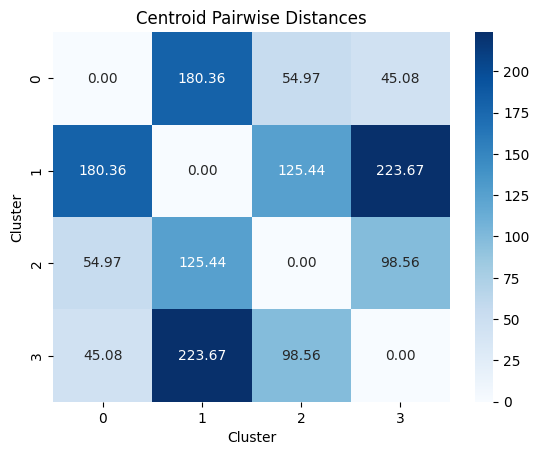

In [80]:
# Plot heatmap for centroid distances
# plt.figure(figsize=(8, 6))
sns.heatmap(centroid_distances, annot=True, fmt='.2f', cmap='Blues', xticklabels=centroids.index, yticklabels=centroids.index)
plt.title('Centroid Pairwise Distances')
plt.xlabel('Cluster')
plt.ylabel('Cluster')

plt.show()

### Clusters Behaviors

In [73]:
# Create a parallel coordinates plot using Plotly
fig = px.parallel_coordinates(
    df_customer_abt,
    dimensions=['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount'],
    color='cluster_kmeans',
    color_continuous_scale=px.colors.qualitative.Set2,
)

# Update layout for a clean design
fig.update_layout(
    title='Parallel Coordinates Plot for Customer Segmentation',
    title_x=0.5,  # Center title
    title_y=0.99,  # Move title upwards (default is 1.0)
    font=dict(size=12),
    plot_bgcolor="white"
)

# Show the plot
fig.show()

In [83]:
# Get the unique clusters
clusters = df_customer_abt_scaled['cluster_kmeans'].unique()

# Create the radar chart
fig = go.Figure()

# Loop through each cluster and add a trace
for cluster in clusters:
    cluster_data = df_customer_abt_scaled[df_customer_abt_scaled['cluster_kmeans'] == cluster]
    
    # Calculate the mean for each feature in the cluster
    mean_values = cluster_data[['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']].mean()
    
    # Add the trace for this cluster
    fig.add_trace(go.Scatterpolar(
        r=mean_values.values,  # Values for each axis
        theta=mean_values.index,  # Feature names
        fill='toself',  # Fill the area under the line
        name=f'Cluster {cluster}',  # Name for the trace
        line=dict(color=px.colors.qualitative.Set2[int(cluster) % len(px.colors.qualitative.Set2)])  # Use a discrete color for each cluster
    ))

# Update layout for a clean design
fig.update_layout(
    title='Radar Chart for Customer Segmentation by Cluster',
    title_x=0.5,  # Center title
    polar=dict(
        radialaxis=dict(range=[0, df_customer_abt_scaled[['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']].max().max()]),  # Set the range of the radial axis
    ),
    font=dict(size=12),
    plot_bgcolor="white"
)

# Show the plot
fig.show()

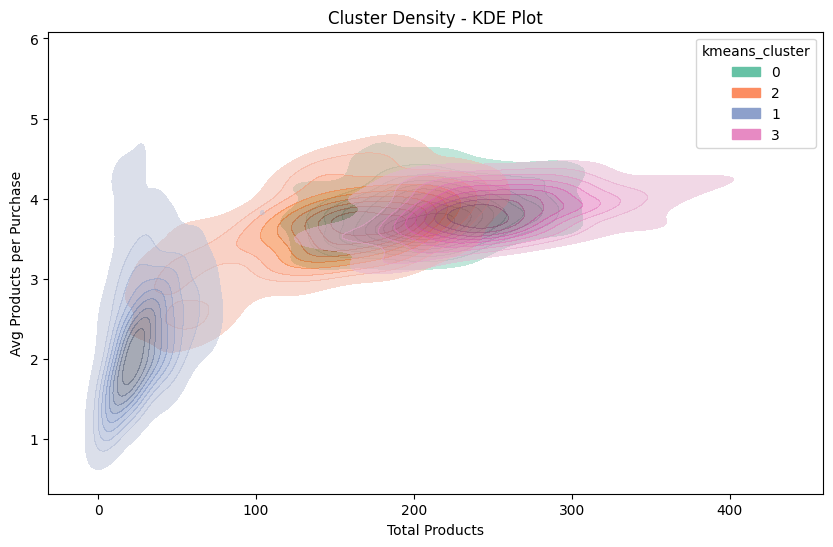

In [83]:
# Plot KDE for each cluster
plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=df_customer_abt,
    x='total_products',
    y='avg_produtcs_per_purchase',
    hue='cluster_kmeans',
    fill=True,  # Fill the area under the curve
    common_norm=False,  # Normalize separately for each cluster
    palette='Set2'  # Color palette for the clusters
    , alpha=0.5
)

plt.title('Cluster Density - KDE Plot')
plt.xlabel('Total Products')
plt.ylabel('Avg Products per Purchase')
plt.show()

### In Depth Analysis

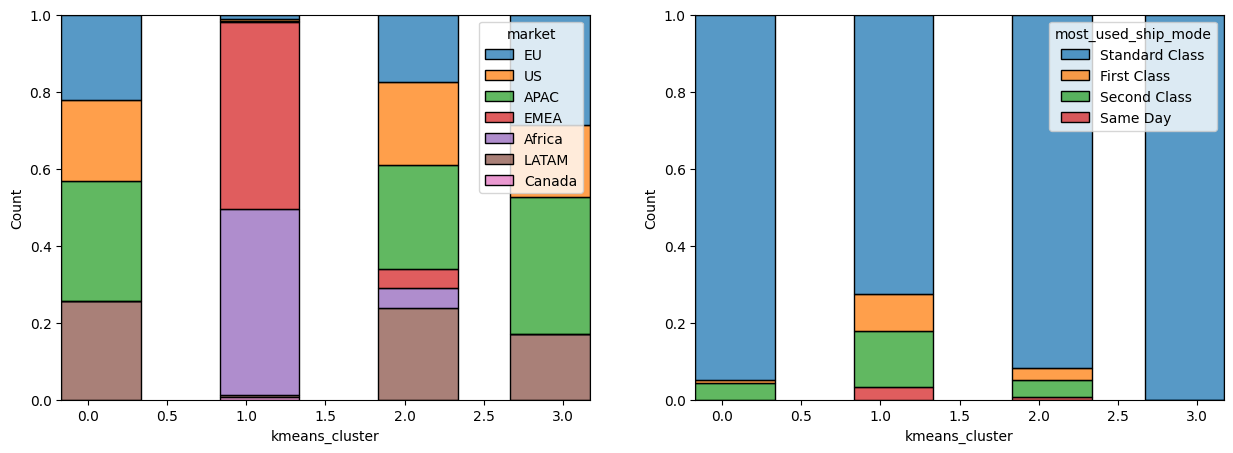

In [111]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df_customer_abt, x='cluster_kmeans', hue='market', multiple='fill', shrink=3)
plt.subplot(1,2,2)
sns.histplot(data=df_customer_abt, x='cluster_kmeans', hue='most_used_ship_mode', multiple='fill', shrink=3)
plt.show()

In [88]:
variable_a = 'avg_ticket'
variables = ['total_products', 'avg_produtcs_per_purchase', 'avg_profit', 'avg_discount']
rows=4; cols=2

df_customer_abt.columns

Index(['Customer ID', 'total_sales', 'avg_ticket', 'total_products',
       'avg_produtcs_per_purchase', 'median_discount', 'avg_discount',
       'std_discount', 'total_profit', 'avg_profit', 'total_shipping_cost',
       'avg_shipping_cost', 'segment', 'market', 'most_used_ship_mode',
       'kmeans_cluster'],
      dtype='object')

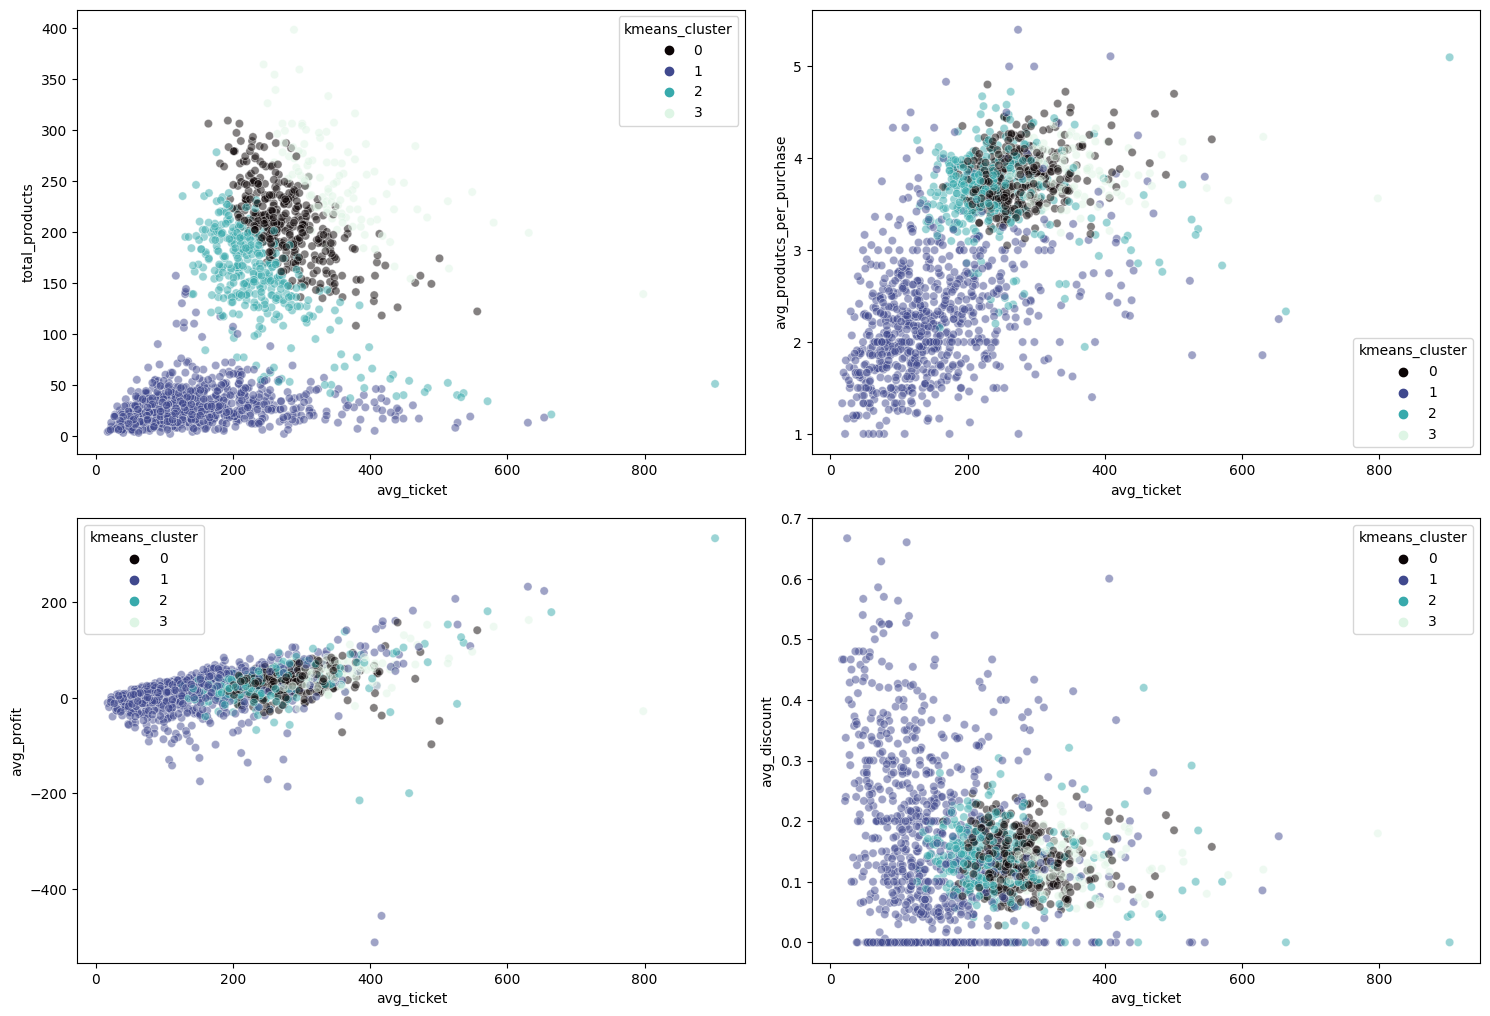

In [91]:
plt.figure(figsize=(15,20))

plt.subplot(rows, cols, 1)
sns.scatterplot(data=df_customer_abt, x=variable_a, y=variables[0], hue='cluster_kmeans', palette='mako', alpha=0.5)

plt.subplot(rows, cols, 2)
sns.scatterplot(data=df_customer_abt, x=variable_a, y=variables[1], hue='cluster_kmeans', palette='mako', alpha=0.5)

plt.subplot(rows, cols, 3)
sns.scatterplot(data=df_customer_abt, x=variable_a, y=variables[2], hue='cluster_kmeans', palette='mako', alpha=0.5)

plt.subplot(rows, cols, 4)
sns.scatterplot(data=df_customer_abt, x=variable_a, y=variables[3], hue='cluster_kmeans', palette='mako', alpha=0.5)

plt.tight_layout()
plt.show()

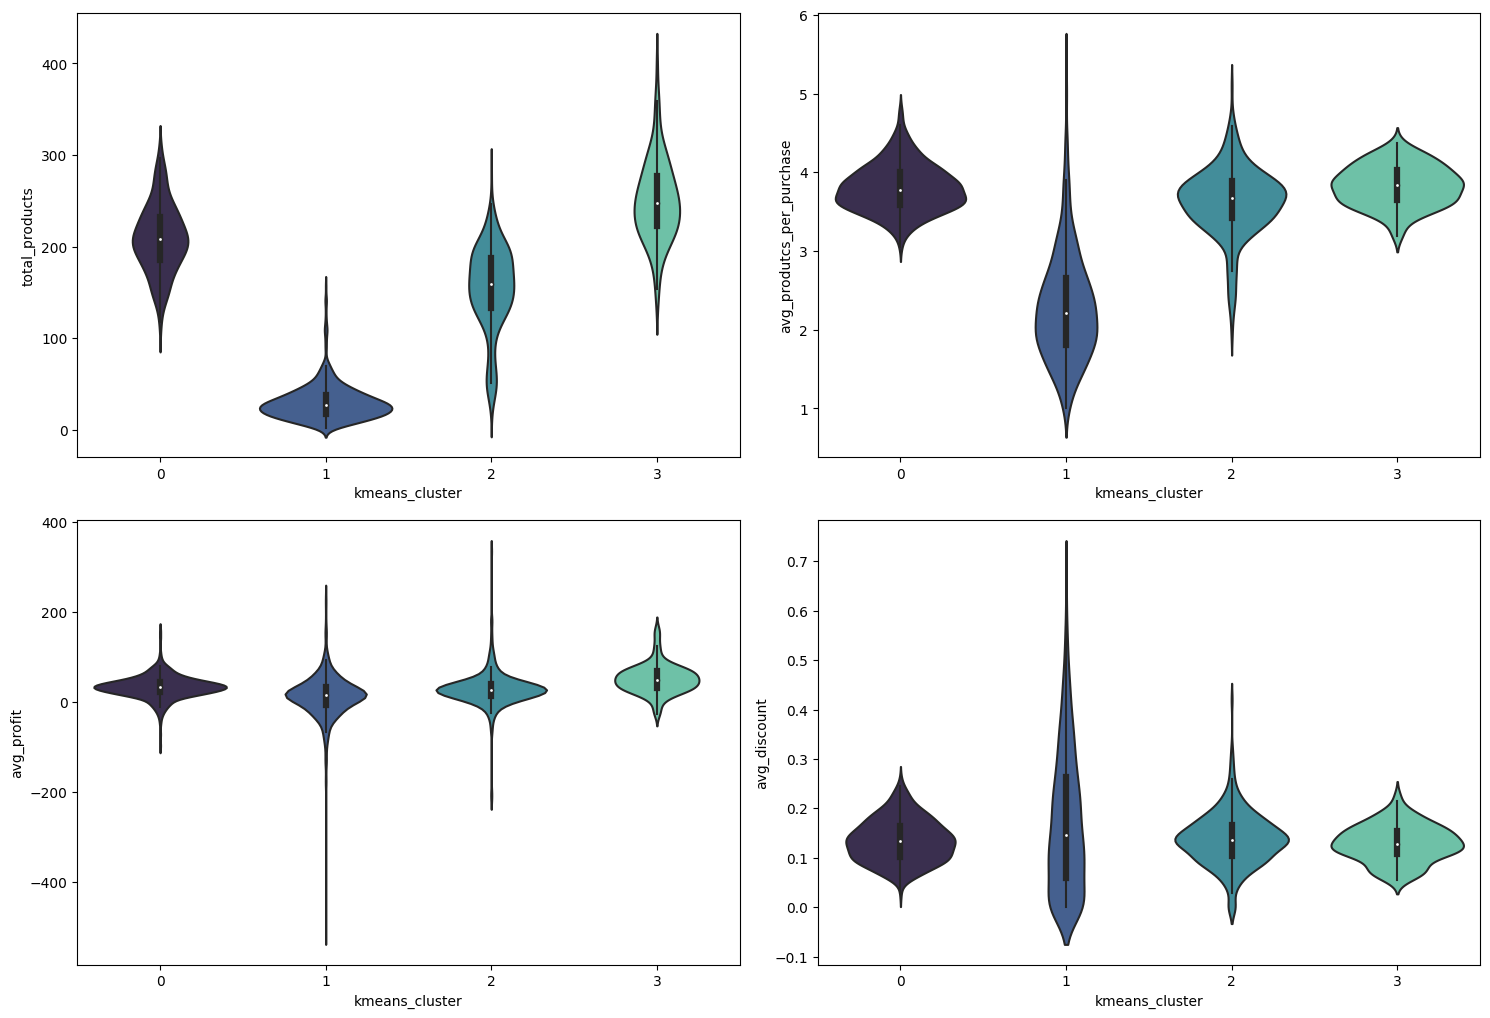

In [122]:
plt.figure(figsize=(15,20))

plt.subplot(rows, cols, 1)
sns.violinplot(data=df_customer_abt, x='cluster_kmeans', y=variables[0], palette='mako')

plt.subplot(rows, cols, 2)
sns.violinplot(data=df_customer_abt, x='cluster_kmeans', y=variables[1], palette='mako')

plt.subplot(rows, cols, 3)
sns.violinplot(data=df_customer_abt, x='cluster_kmeans', y=variables[2], palette='mako')

plt.subplot(rows, cols, 4)
sns.violinplot(data=df_customer_abt, x='cluster_kmeans', y=variables[3], palette='mako')

plt.tight_layout()
plt.show()

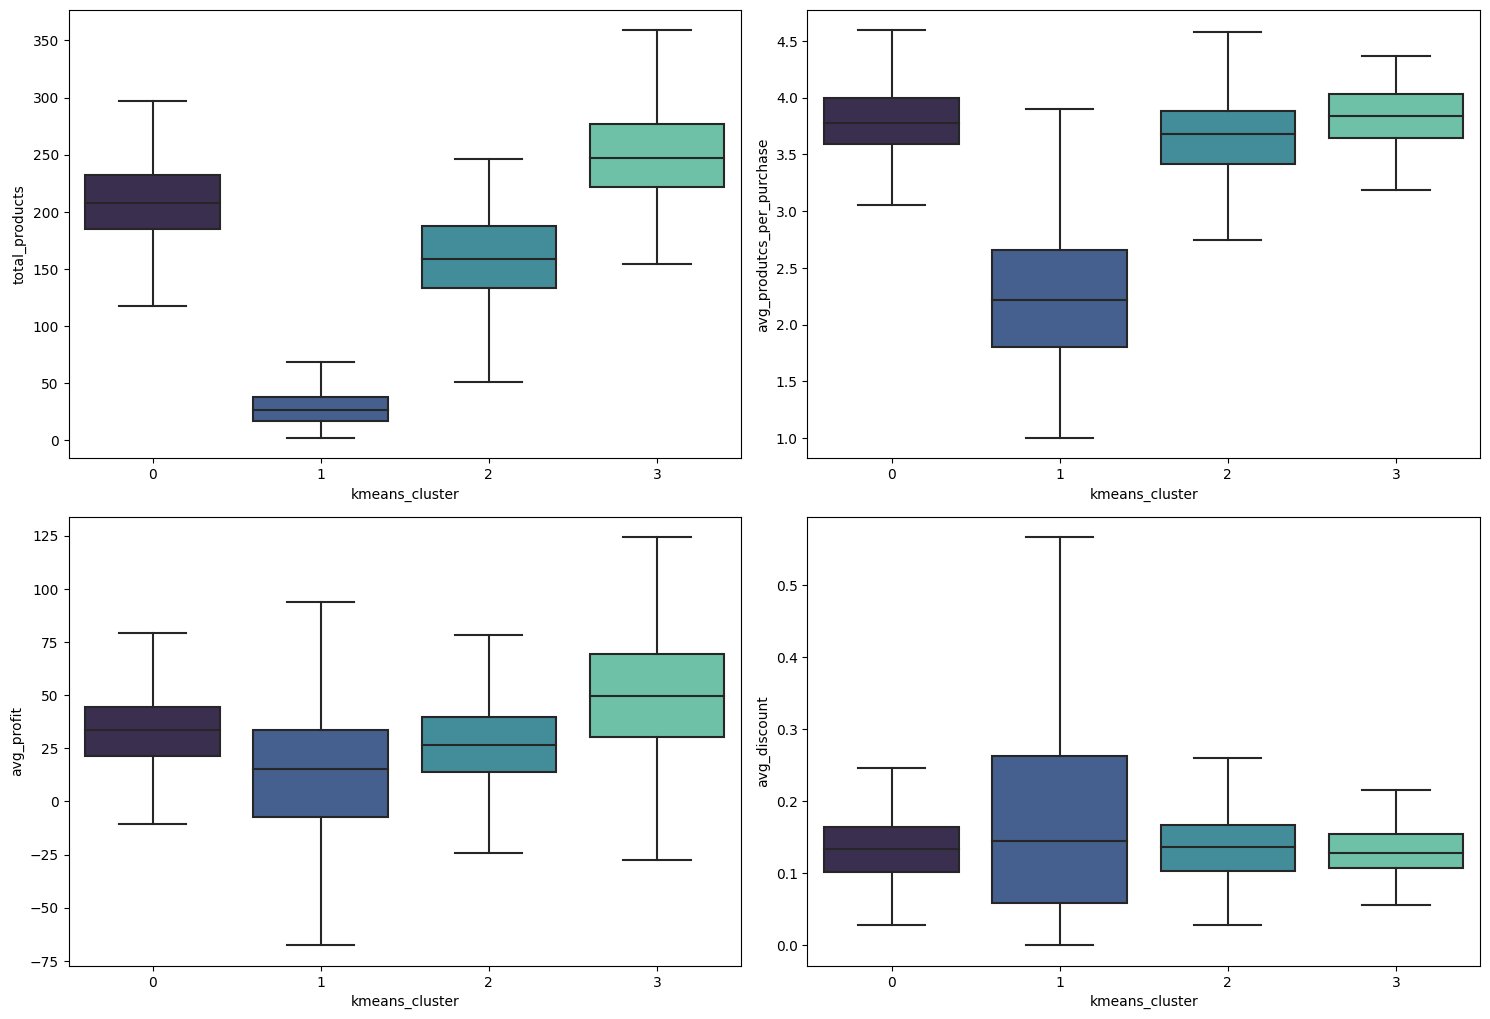

In [92]:
plt.figure(figsize=(15,20))

plt.subplot(rows, cols, 1)
sns.boxplot(data=df_customer_abt, x='cluster_kmeans', y=variables[0], showfliers=False, palette='mako')

plt.subplot(rows, cols, 2)
sns.boxplot(data=df_customer_abt, x='cluster_kmeans', y=variables[1], showfliers=False, palette='mako')

plt.subplot(rows, cols, 3)
sns.boxplot(data=df_customer_abt, x='cluster_kmeans', y=variables[2], showfliers=False, palette='mako')

plt.subplot(rows, cols, 4)
sns.boxplot(data=df_customer_abt, x='cluster_kmeans', y=variables[3], showfliers=False, palette='mako')

plt.tight_layout()
plt.show()

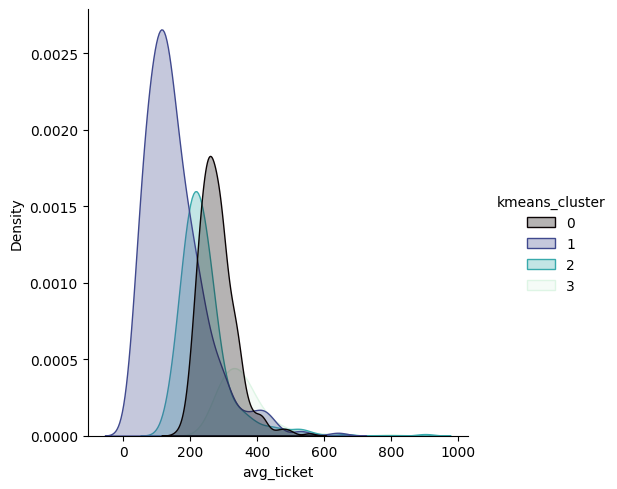

In [134]:
# sns.histplot(df_customer_abt, x='avg_ticket', hue='cluster_kmeans', element='step', palette='mako')
sns.displot(df_customer_abt, x='avg_ticket', hue='cluster_kmeans', kind='kde', fill=True, alpha=0.3, palette='mako')

### Cluster Profiles

In [60]:
cluster_col = 'cluster_kmeans'
df_customer_abt[analysis_cols+[cluster_col]].groupby([cluster_col]).describe()

total_sales                                          \
                     count          mean          std          min   
kmeans_cluster                                                       
0                    353.0  15031.495150  1864.980623  12108.30958   
1                    772.0   1954.284485  1344.910359     52.04700   
2                    346.0   9470.851254  1795.434728   5689.26300   
3                    112.0  22768.126485  3610.637266  18725.38964   

                                                                   avg_ticket  \
                        25%          50%          75%          max      count   
kmeans_cluster                                                                  
0               13405.60130  14689.34250  16552.06996  19218.81298      353.0   
1                 926.87475   1649.36400   2733.62250   5765.40000      772.0   
2                8092.03055   9752.26435  10900.27161  12864.72050      346.0   
3               20131.31960  21901.46072  24232.17385  35668.12080      112.0   

                                                                           \
                      mean        std         min         25%         50%   
kmeans_cluster                                                              
0               279.718885  54.387180  164.159131  242.192232  271.492877   
1               153.934345  91.587364   17.349000   90.848711  133.405750   
2               241.157400  81.595902  126.626785  194.627735  225.459635   
3               356.826385  80.184233  244.615402  304.414676  342.398917   

                                       total_products                         \
                       75%         max          count        mean        std   
kmeans_cluster                                                                 
0               304.805378  556.082428          353.0  209.104816  37.387525   
1               194.548667  653.639250          772.0   29.873057  19.393915   
2               262.463022  902.748000          346.0  154.312139  46.485163   
3               382.906338  798.084486          112.0  250.151786  44.745972   

                                                   avg_produtcs_per_purchase  \
                  min    25%    50%     75%    max                     count   
kmeans_cluster                                                                 
0               108.0  185.0  208.0  232.00  309.0                     353.0   
1                 2.0   17.0   27.0   38.00  157.0                     772.0   
2                21.0  133.0  159.0  188.00  278.0                     346.0   
3               139.0  222.0  247.5  277.25  398.0                     112.0   

                                                                            \
                    mean       std       min       25%       50%       75%   
kmeans_cluster                                                               
0               3.802518  0.298822  3.051724  3.589286  3.779661  4.000000   
1               2.288957  0.691010  1.000000  1.800000  2.214286  2.657051   
2               3.627949  0.434828  1.947368  3.415627  3.677460  3.883798   
3               3.831195  0.257446  3.189655  3.644004  3.838562  4.032923   

                         median_discount                                     \
                     max           count      mean       std  min  25%  50%   
kmeans_cluster                                                                
0               4.803279           353.0  0.045487  0.064077  0.0  0.0  0.0   
1               5.400000           772.0  0.101860  0.219884  0.0  0.0  0.0   
2               5.100000           346.0  0.047971  0.075439  0.0  0.0  0.0   
3               4.367647           112.0  0.034563  0.051734  0.0  0.0  0.0   

                         avg_discount                                          \
                75%  max        count      mean       std       min       25%   
kmeans_cluster                 

In [63]:
df_customer_abt[['avg_profit', 'avg_produtcs_per_purchase', 'avg_ticket', 'avg_discount', 'avg_shipping_cost']+[cluster_col]].groupby([cluster_col]).describe().T

kmeans_cluster                            0           1           2  \
avg_profit                count  353.000000  772.000000  346.000000   
                          mean    32.953438   12.835755   28.584605   
                          std     25.382956   49.781004   38.288575   
                          min    -97.181617 -511.770000 -214.578937   
                          25%     21.516478   -7.243400   13.687291   
                          50%     33.714463   15.219727   26.760595   
                          75%     44.605409   33.440332   39.495716   
                          max    157.718306  232.661143  334.134000   
avg_produtcs_per_purchase count  353.000000  772.000000  346.000000   
                          mean     3.802518    2.288957    3.627949   
                          std      0.298822    0.691010    0.434828   
                          min      3.051724    1.000000    1.947368   
                          25%      3.589286    1.800000    3.415627   
                          50%      3.779661    2.214286    3.677460   
                          75%      4.000000    2.657051    3.883798   
                          max      4.803279    5.400000    5.100000   
avg_ticket                count  353.000000  772.000000  346.000000   
                          mean   279.718885  153.934345  241.157400   
                          std     54.387180   91.587364   81.595902   
                          min    164.159131   17.349000  126.626785   
                          25%    242.192232   90.848711  194.627735   
                          50%    271.492877  133.405750  225.459635   
                          75%    304.805378  194.548667  262.463022   
                          max    556.082428  653.639250  902.748000   
avg_discount              count  353.000000  772.000000  346.000000   
                          mean     0.135272    0.172308    0.137548   
                          std      0.042905    0.142056    0.053224   
                          min      0.027841    0.000000    0.000000   
                          25%      0.102326    0.058333    0.103245   
                          50%      0.133036    0.145299    0.136739   
                          75%      0.164444    0.262500    0.166452   
                          max      0.258258    0.666667    0.420000   
avg_shipping_cost         count  353.000000  772.000000  346.000000   
                          mean    30.156771   17.056846   26.041664   
                          std      7.552972   12.502609   10.891646   
                          min     16.677258    1.646667   10.617143   
                          25%     24.829667    8.975028   19.475156   
                          50%     28.940385   13.949000   23.191193   
                          75%     33.835769   21.267589   29.490237   
                          max     56.504828  131.441429  115.358000   

kmeans_cluster                            3  
avg_profit                count  112.000000  
                          mean    51.601363  
                          std     32.623270  
                          min    -27.786522  
                          25%     30.234919  
                          50%     49.387303  
                          75%     69.331613  
                          max    162.925570  
avg_produtcs_per_purchase count  112.000000  
                          mean     3.831195  
                          std      0.257446  
                          min      3.189655  
                          25%      3.644004  
                          50%      3.838562  
                          75%      4.032923  
                          max      4.367647  
avg_ticket                count  112.000000  
                          mean   356.826385  
                          std     80.184233  
                          min    244.615402  
                          25%    304.414676  
                          50%    342.398917  
                          75% 

<Axes: xlabel='kmeans_cluster', ylabel='None-None'>

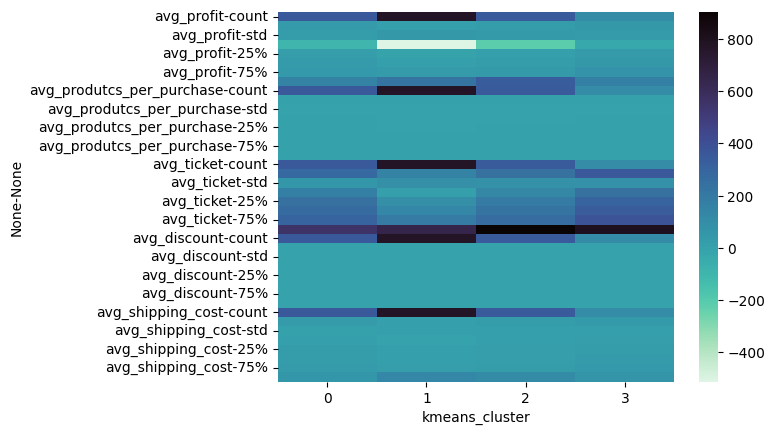

In [66]:
sns.heatmap(df_customer_abt[['avg_profit', 'avg_produtcs_per_purchase', 'avg_ticket', 'avg_discount', 'avg_shipping_cost']+[cluster_col]].groupby(cluster_col)
            .describe().T, annot=False, cmap='mako_r')

### Customer Profiles/Business Opportunity Map

### K-Means

| Cluster Name         | Avg Profit | Avg Ticket | Discount Sensitivity | Strategic Approach                                                    |
|-----------------------|------------|------------|-----------------------|------------------------------------------------------------------------|
| **Premium Shoppers** | High       | High       | Moderate              | Loyalty programs, premium shipping, personalized marketing.            |
| **Bargain Hunters**   | Low        | Low        | High                  | Flash sales, product bundles, free/low-cost shipping.                  |
| **Consistent Buyers** | Moderate   | Moderate   | Low                   | Loyalty programs, upselling, moderate discounts.                       |
| **Luxury Enthusiasts**| Highest    | Highest    | Lowest                | Exclusive experiences, premium memberships, expedited services.        |

### DBSCAN

| Cluster Name         | Feature A | Feature B | Feature C | Strategic Approach                                                    |
|-----------------------|------------|------------|-----------------------|------------------------------------------------------------------------|
| **Cluster Name** | VALUE       | VALUE       | VALUE              | Strategy.            |

### AgglomerativeClustering

| Cluster Name         | Feature A | Feature B | Feature C | Strategic Approach                                                    |
|-----------------------|------------|------------|-----------------------|------------------------------------------------------------------------|
| **Cluster Name** | VALUE       | VALUE       | VALUE              | Strategy.            |

### Business Descriptions


### K-Means

**Cluster 0: "Premium Shoppers"** 

- **Business Description:**
    
    High-value customers who prioritize quality and convenience. They consistently purchase multiple products per transaction and are willing to spend more on average. They appreciate thoughtful service and added value but show moderate responsiveness to discounts.

- **Key Attributes:**

    Loyal and profitable.
    Frequently purchase high-ticket items.
    Moderate price sensitivity.

- **Business Objective:**
    
    Retain and grow this segment by enhancing customer loyalty and maintaining their premium experience.

**Cluster 1: "Bargain Hunters"**

- **Business Description:**

    Customers who focus on finding the best deals and minimizing expenses. They typically make smaller transactions and are highly responsive to discounts and promotions. They avoid spending on shipping or additional costs.

- **Key Attributes:**

    Price-sensitive and deal-driven.
    Contribute to volume over profit.
    High potential for conversion with targeted promotions.

- **Business Objective:**

    Increase transaction size and frequency by offering value bundles and targeted discounts without compromising margins.

**Cluster 2: "Consistent Buyers"**

- **Business Description:**

    Stable customers with predictable buying patterns. They make moderately priced transactions and purchase multiple products per order. They value consistency and trust in the company, responding well to modest incentives.

- **Key Attributes:**

    Reliable revenue stream.
    Moderate profit contribution.
    Loyal with steady growth potential.

- **Business Objective:**

    Strengthen relationships by fostering loyalty, offering upselling opportunities, and maintaining their satisfaction with consistent service quality.

**Cluster 3: "Luxury Enthusiasts"**

- **Business Description:

    Elite customers who gravitate toward high-end products and premium services. They make the highest-value transactions and exhibit low sensitivity to discounts. They are willing to pay for exceptional shipping and personalized offerings.

- **Key Attributes:**

    Significant profit contributors.
    Seek exclusivity and quality.
    Low price sensitivity.

- **Business Objective:**
    
    Maximize lifetime value by delivering bespoke experiences, offering exclusive access to luxury items, and ensuring premium service quality.



#### Strategic Alignment with Business Goals

1. Revenue Growth:

    Focus on Premium Shoppers and Luxury Enthusiasts to maximize profits. Develop tailored offers for Bargain Hunters to increase sales volume.

2. Customer Retention:

    Strengthen loyalty for Consistent Buyers and Premium Shoppers with targeted loyalty programs.

3. Brand Positioning:

    Emphasize premium quality and exclusivity for Luxury Enthusiasts while maintaining affordability for Bargain Hunters.

4. Operational Efficiency:

    Optimize shipping and pricing strategies to balance the needs of Bargain Hunters and Luxury Enthusiasts without compromising profit margins.

### DBSCAN


TO DO

### AgglomerativeClustering

TO DO